In [1]:
import numpy
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
import math
import tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Concatenate, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,  mean_absolute_error, r2_score
 
# tensorflow.reset_default_graph()
tensorflow.random.set_seed(0)
# random.seed(0)
numpy.random.seed(0)

In [2]:
def create_dataset(dataset, look_back=14, day_offset=5):
    dataY= []
    dataX1=numpy.zeros([(len(dataset)-look_back),2,look_back])
    dataX2=numpy.zeros([(len(dataset)-look_back),2,look_back])
    dataX3=numpy.zeros([(len(dataset)-look_back),2,look_back])
    
    #print(dataX.shape)
    for i in range(look_back,len(dataset)):
       # print(i)
        a = numpy.zeros([6,look_back])
        t1=dataset[(i-look_back):i, 0]
        t1=numpy.reshape(t1,[1,look_back])
        t4=dataset[(i-look_back):i, 48]
        t4=numpy.reshape(t4,[1,look_back])
        #print(t1.shape)
        t2=dataset[i, 48-look_back:48]
        t2=numpy.reshape(t2,[1,look_back])
        t6=dataset[i,-(look_back+3):-3]
        t6=numpy.reshape(t6,[1,look_back])
        t3=numpy.zeros([1,look_back])
        if i>=((day_offset+1)*7+look_back):
            t3[0,0:day_offset]=[dataset[j,0] for j in range(i-(((day_offset+1)*7)+look_back),i-(look_back+7),7)]
        t5=numpy.zeros([1,look_back])
        if i>=((day_offset+1)*7+look_back):
            t5[0,0:day_offset]=[dataset[j,48] for j in range(i-(((day_offset+1)*7)+look_back),i-(look_back+7),7)]
            
            
        #print(t2.shape)
        a[0,:] = t1
        a[1,:] = t4
        a[2,:] = t2
        a[3,:] = t6
        a[4,:] = t3
        a[5,:] = t5
        dataX1[i-look_back,:,:]=a[0:2,:]
        dataX2[i-look_back,:,:]=a[2:4,:]
        dataX3[i-look_back,:,:]=a[4:,:]
#         a = numpy.concatenate([dataset[(i-look_back-7):i-7, 0], dataset[i,-14:]],axis=1)
        
        #dataX.append(a)
        dataY.append(dataset[i,-1])
    return numpy.array(dataX1),numpy.array(dataX2),numpy.array(dataX3),numpy.array(dataY)

In [3]:
def missing_values(datarange, categorical=[]):  
    datarange= pd.DataFrame(datarange)
    if not categorical:
        meandata=datarange.mean()
        meandata=meandata.to_numpy()
    else:
        meandata=datarange.mean()
        meandata=meandata.to_numpy()
        
        modedata = datarange.mode()
        modedata = modedata.to_numpy()
        modedata = modedata[0,:]
        
        for i in categorical:
                meandata[i-1] = modedata[i]
                
    datetime_series = pd.to_datetime(datarange['fltdat'])
    miss_idx=pd.date_range(start = '01-01-2015', end = '31-12-2019' ).difference(datetime_series)
    datetime_index = pd.DatetimeIndex(datetime_series.values)
    datarange=datarange.set_index(datetime_index)

    datarange.drop('fltdat',axis=1,inplace=True)
    newidx = pd.date_range('01-01-2015', '31-12-2019')
    datarange = datarange.reindex(newidx, fill_value=0)
    
    meandata=meandata.reshape(1,meandata.shape[0])
    dat = numpy.tile(meandata, [miss_idx.shape[0],1])
    datarange.loc[miss_idx]=dat
    return datarange

In [4]:
def mean_absolute_percentage_error(y_test, y_pred):
        import numpy as np
        t = np.array(y_test)
        p = np.array(y_pred)
        mae = list()
        mape = list()
        for i in range(len(t)):
            if (t[i] == 0):
                mae.append(abs(p[i]))
            else:
                mae.append(float(abs(t[i] - p[i])))
                mape.append(float(abs((t[i] - p[i])/t[i])))
        return np.mean(mae) , np.mean(mape)

In [5]:
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('data/rmscapfc.csv', parse_dates=['fltdat'],dayfirst=True)
print(dataframe.columns)
dataframe.drop(dataframe.columns[[2,3,4,6,8,9,10,56,57,58,59,60,61,62] ], axis=1, inplace=True)

dataframe2 = read_csv('data/rmscapy.csv', parse_dates=['fltdat'],dayfirst=True)
# print(dataframe2.columns)
f_column = dataframe2[["paxcnty", "dcp_51", "dcp_50", "dcp_49", "dcp_48", "dcp_47", "dcp_46",
       "dcp_45", "dcp_44", "dcp_43", "dcp_42", "dcp_41", "dcp_40", "dcp_39",
       "dcp_38", "dcp_37", "dcp_36", "dcp_35", "dcp_34", "dcp_33", "dcp_3",
       "dcp_31", "dcp_30", "dcp_29", "dcp_28", "dcp_27", "dcp_26", "dcp_25",
       "dcp_24", "dcp_23", "dcp_22", "dcp_21", "dcp_20", "dcp_19", "dcp_18",
       "dcp_17", "dcp_16", "dcp_15", "dcp_14", "dcp_13", "dcp_12", "dcp_11",
       "dcp_10", "dcp_9", "dcp_8"]]
 

dataframe = pd.concat([dataframe,f_column], axis = 1)
# print(dataframe.columns)
dataframe3 = read_csv('data/uldfc.csv', parse_dates=['fltdat'],dayfirst=True)

dataframe3.drop(dataframe3.columns[[1,2,3] ], axis=1, inplace=True)
dataframe4 = read_csv('data/uldy.csv', parse_dates=['fltdat'],dayfirst=True)
dataframe4.drop(dataframe4.columns[[1,2,3] ], axis=1, inplace=True)
f_column = dataframe4[["county"]]
dataframe3 = pd.concat([dataframe3,f_column], axis = 1)
print(dataframe.columns)

Index(['fltdat', 'paxcntfc', 'fltnum', 'legorg', 'legdst', 'acrtypcod',
       'keyidr', 'totpaylodwgt', 'totpaylodvol', 'totpaylodpos', 'totsetfc',
       'totpaxwgt', 'dp_51', 'dp_50', 'dp_49', 'dp_48', 'dp_47', 'dp_46',
       'dp_45', 'dp_44', 'dp_43', 'dp_42', 'dp_41', 'dp_40', 'dp_39', 'dp_38',
       'dp_37', 'dp_36', 'dp_35', 'dp_34', 'dp_33', 'dp_32', 'dp_31', 'dp_30',
       'dp_29', 'dp_28', 'dp_27', 'dp_26', 'dp_25', 'dp_24', 'dp_23', 'dp_22',
       'dp_21', 'dp_20', 'dp_19', 'dp_18', 'dp_17', 'dp_16', 'dp_15', 'dp_14',
       'dp_13', 'dp_12', 'dp_11', 'dp_10', 'dp_9', 'dp_8', 'dp_7', 'dp_6',
       'dp_5', 'dp_4', 'dp_3', 'dp_2', 'dp_1'],
      dtype='object')
Index(['fltdat', 'paxcntfc', 'acrtypcod', 'totpaylodwgt', 'totpaxwgt', 'dp_51',
       'dp_50', 'dp_49', 'dp_48', 'dp_47', 'dp_46', 'dp_45', 'dp_44', 'dp_43',
       'dp_42', 'dp_41', 'dp_40', 'dp_39', 'dp_38', 'dp_37', 'dp_36', 'dp_35',
       'dp_34', 'dp_33', 'dp_32', 'dp_31', 'dp_30', 'dp_29', 'dp_28', 'dp_27',

In [6]:
NUM=[0,1825,1825,1817,1816,1812,1821,1825,1824,1819,1825,1825,1824,1826,1819,1825,1822,1823,1813, 1826, 1820]
NUMuld=[0,1817,1574,1808,1802,1807,1808,1730,1817,1385,1820,1816,1606,1819,1810,1817,421,1813,434,1532,1814]
cat_inp=[2]

In [7]:
# dataset, datasetY = numpy.empty([1805,3,look_back]), []
for i in range(0,len(NUM)-1):
#     print(i)
    datasub = dataframe.iloc[sum(NUM[0:i+1]):sum(NUM[0:i+2]),:]
#     datasub=datasetall[sum(NUM[0:i+1]):sum(NUM[0:i+2]),:]
    datasub = missing_values(datasub, cat_inp)
    datasub = datasub.values
    datasub = datasub.astype('float32')
    
    datasubuld = dataframe3.iloc[sum(NUMuld[0:i+1]):sum(NUMuld[0:i+2]),:]
#     datasub=datasetall[sum(NUM[0:i+1]):sum(NUM[0:i+2]),:]
    datasubuld = missing_values(datasubuld)
    datasubuld = datasubuld.values
    datasubuld = datasubuld.astype('float32')
    
    datasub = numpy.concatenate([datasub, datasubuld], axis=1)
    if i==0:
        data = datasub
    else:
        data = numpy.concatenate([data, datasub], axis =0)
 

C:\Users\iist\anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  import sys
C:\Users\iist\anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  after removing the cwd from sys.path.


In [8]:
out = data[:,2] - data[:,3] - (data[:,-1]*data[:,-2]*114)
out = out.reshape(out.shape[0],1)
data = numpy.concatenate([data,out], axis=1)
print(data.shape)

(36520, 96)


In [9]:
scaler = MinMaxScaler(feature_range=(-1, 1))
data = scaler.fit_transform(data)

In [10]:
def sequence_data_build(data, look_back):
    for i in range(0,20):
        datasub = data[i*1826:((i+1)*1826),:]
        X1, X2, X3, Y = create_dataset(datasub, look_back)
        Y = Y.reshape(Y.shape[0],1)
        if i==0: 
            data_LSTM_X1, data_LSTM_X2, data_LSTM_X3 = X1, X2, X3
            data_LSTM_Y = Y
        else:
            data_LSTM_X1,data_LSTM_X2, data_LSTM_X3 = numpy.concatenate([data_LSTM_X1, X1],axis=0), numpy.concatenate([data_LSTM_X2, X2],axis=0),  numpy.concatenate([data_LSTM_X3, X3],axis=0)  
            data_LSTM_Y = numpy.concatenate([data_LSTM_Y, Y],axis=0)
    return data_LSTM_X1, data_LSTM_X2, data_LSTM_X3, data_LSTM_Y

In [11]:
def train_test_build(X, Y, m1, m2):
    spliter = int(X.shape[0]/20)
    tot_len = m1
    train_len = m2
    for i in range(0,20):
        Xsub = X[i*spliter:((i+1)*spliter),:]
        Ysub = Y[i*spliter:((i+1)*spliter)]
        if i==0:
            trainX = Xsub[0:m2,:]
            testX = Xsub[m2:m1,:]
            trainY = Ysub[0:m2]
            testY = Ysub[m2:m1]
        else:
            trainX = numpy.concatenate([trainX, Xsub[0:m2,:]], axis=0)
            testX = numpy.concatenate([testX, Xsub[m2:m1,:]], axis=0)
            trainY = numpy.concatenate([trainY, Ysub[0:m2]], axis=0)
            testY = numpy.concatenate([testY, Ysub[m2:m1]], axis=0)
        
    return trainX, trainY, testX, testY

In [12]:
def model_build(trainX1, trainX2, trainX3, testX1, testX2, testX3, trainY, testY, units, saving =False, month=None, EarlyStop = False):
    
    if EarlyStop:
        callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                                            mode = 'min', restore_best_weights=True)
    
    inp1 = Input(shape=(2, trainX1.shape[2]))
    inp2 = Input(shape=(2, trainX2.shape[2]))
    inp3 = Input(shape=(2, trainX3.shape[2]))

    LS1 = LSTM(units, input_shape=(2, trainX1.shape[2]))
    out1 = LS1(inp1)
    LS2 = LSTM(units, input_shape=(2, trainX2.shape[2]))
    out2 = LS2(inp2)
    LS3 = LSTM(units, input_shape=(2, trainX3.shape[2]))
    out3 = LS3(inp3)

    mrg = Concatenate(axis=1)([out1,out2,out3])
    op = Dense(1)(mrg)

    model = Model(inputs=[inp1, inp2, inp3], outputs=op)
#     model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    if EarlyStop:
        history =model.fit([trainX1, trainX2, trainX3], trainY, epochs=100, batch_size=150, 
                           validation_data=([testX1,testX2,testX3], testY),verbose=1,callbacks=[callback])
    else:
        history =model.fit([trainX1, trainX2, trainX3], trainY, epochs=100, batch_size=150, 
                           validation_data=([testX1,testX2,testX3], testY),verbose=1)
                
    testPredict = model.predict([testX1,testX2,testX3])
                
    sh = testPredict.shape
    inv_yhat = testPredict.reshape(sh[0]*sh[1],1)
    inv_yhat = numpy.concatenate([ data[0:inv_yhat.shape[0],0:95], inv_yhat], axis=1)

    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-1]
    testY = testY.reshape(sh[0]*sh[1],1)
 
    inv_y = numpy.concatenate([data[0:testY.shape[0],0:95], testY], axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,-1]
             
    rmse = numpy.sqrt(mean_squared_error(inv_y, inv_yhat))
    mae, mape = mean_absolute_percentage_error(inv_y, inv_yhat) 
    r2 = r2_score(inv_y, inv_yhat)
    
    res=[]
    if saving:
        inv_y = inv_y.reshape(inv_y.shape[0],1) 
        inv_yhat = inv_yhat.reshape(inv_yhat.shape[0],1) 
        res = numpy.concatenate([inv_y, inv_yhat], axis=1)
        df = pd.DataFrame(res)
        res = df.to_csv("ds_" + month + ".csv", index = False)
    return rmse, mape,mae,r2, history

In [13]:
def cross_validation(lag_vec = [7,14,21,28], units_vec = [2,4,8,16,32,64,128]):
    results = numpy.zeros([4,3,len(lag_vec),len(units_vec)])
    
    for folds in range(0,3):
        for i in range(0,len(lag_vec)):
            data_LSTM_X1,data_LSTM_X2,data_LSTM_X3,data_LSTM_Y = sequence_data_build(data, lag_vec[i])
            totday = int(data_LSTM_X1.shape[0]/20)
            m1 = [totday-152, totday-121, totday-91, ]
            m2 = [m1[0]-31, m1[1]-31, m1[2]-30, ]
            lag = lag_vec[i]
            trainX1, trainY, testX1, testY= train_test_build(data_LSTM_X1, data_LSTM_Y, m1[folds], m2[folds])
            trainX2, trainY, testX2, testY= train_test_build(data_LSTM_X2, data_LSTM_Y, m1[folds], m2[folds])
            trainX3, trainY, testX3, testY= train_test_build(data_LSTM_X3, data_LSTM_Y, m1[folds], m2[folds])
            testYcopy=testY
            for j in range(0, len(units_vec)):
                print(" ")
                print(" ")
                print(" ")
                print("------------------------------------------------")
                print("fold: {0}, lag: {1}, units: {2}".format(folds, lag_vec[i], units_vec[j]))
                units = units_vec[j]
                rmse, mape, mae, r2, his = model_build(trainX1, trainX2, trainX3, testX1, testX2, testX3, trainY, testY, units, EarlyStop = True) 
                results[0,folds,i,j] = rmse 
                results[2,folds,i,j], results[1,folds,i,j] = mae, mape
                results[3,folds,i,j] = r2
    return results        

In [14]:
lag_vec = [7,14]
units_vec = [2,4,8,16,32,64,128]
results = cross_validation(lag_vec, units_vec)


 
 
 
------------------------------------------------
fold: 0, lag: 7, units: 2
Train on 32720 samples, validate on 620 samples
Epoch 1/100
32720/32720 [==============================] - 11s 341us/sample - loss: 0.2193 - val_loss: 0.1510
Epoch 2/100
32720/32720 [==============================] - 3s 84us/sample - loss: 0.1670 - val_loss: 0.1211
Epoch 3/100
32720/32720 [==============================] - 3s 85us/sample - loss: 0.1425 - val_loss: 0.0993
Epoch 4/100
32720/32720 [==============================] - 3s 85us/sample - loss: 0.1306 - val_loss: 0.1015
Epoch 5/100
32720/32720 [==============================] - 3s 87us/sample - loss: 0.1271 - val_loss: 0.0954
Epoch 6/100
32720/32720 [==============================] - 3s 83us/sample - loss: 0.1250 - val_loss: 0.0935
Epoch 7/100
32720/32720 [==============================] - 3s 84us/sample - loss: 0.1235 - val_loss: 0.0933
Epoch 8/100
32720/32720 [==============================] - 3s 85us/sample - loss: 0.1223 - val_loss: 0.0926
Epoch

32720/32720 [==============================] - 9s 290us/sample - loss: 0.1588 - val_loss: 0.1061
Epoch 2/100
32720/32720 [==============================] - 3s 84us/sample - loss: 0.1264 - val_loss: 0.0983
Epoch 3/100
32720/32720 [==============================] - 3s 84us/sample - loss: 0.1222 - val_loss: 0.0962
Epoch 4/100
32720/32720 [==============================] - 3s 81us/sample - loss: 0.1204 - val_loss: 0.0967
Epoch 5/100
32720/32720 [==============================] - 3s 83us/sample - loss: 0.1189 - val_loss: 0.0934
Epoch 6/100
32720/32720 [==============================] - 3s 84us/sample - loss: 0.1180 - val_loss: 0.0960
Epoch 7/100
32720/32720 [==============================] - 3s 86us/sample - loss: 0.1171 - val_loss: 0.1007
Epoch 8/100
32720/32720 [==============================] - 3s 83us/sample - loss: 0.1165 - val_loss: 0.0904
Epoch 9/100
32720/32720 [==============================] - 3s 84us/sample - loss: 0.1158 - val_loss: 0.0951
Epoch 10/100
32720/32720 [=============

Epoch 11/100
32720/32720 [==============================] - 3s 80us/sample - loss: 0.1142 - val_loss: 0.0931
Epoch 12/100
32720/32720 [==============================] - 3s 84us/sample - loss: 0.1133 - val_loss: 0.0907
Epoch 13/100
32720/32720 [==============================] - 3s 85us/sample - loss: 0.1121 - val_loss: 0.0860
Epoch 14/100
32720/32720 [==============================] - 3s 86us/sample - loss: 0.1119 - val_loss: 0.0913
Epoch 15/100
32720/32720 [==============================] - 3s 84us/sample - loss: 0.1107 - val_loss: 0.0872
Epoch 16/100
32720/32720 [==============================] - 3s 78us/sample - loss: 0.1101 - val_loss: 0.0863
Epoch 17/100
32720/32720 [==============================] - 3s 81us/sample - loss: 0.1092 - val_loss: 0.0834
Epoch 18/100
32720/32720 [==============================] - 3s 81us/sample - loss: 0.1080 - val_loss: 0.0799
Epoch 19/100
32720/32720 [==============================] - 3s 81us/sample - loss: 0.1068 - val_loss: 0.0766
Epoch 20/100
32720/

32580/32580 [==============================] - 3s 83us/sample - loss: 0.1136 - val_loss: 0.0961
Epoch 13/100
32580/32580 [==============================] - 3s 86us/sample - loss: 0.1134 - val_loss: 0.0901
Epoch 14/100
32580/32580 [==============================] - 3s 85us/sample - loss: 0.1129 - val_loss: 0.0904
Epoch 15/100
32580/32580 [==============================] - 3s 84us/sample - loss: 0.1125 - val_loss: 0.0916
Epoch 16/100
32580/32580 [==============================] - 3s 80us/sample - loss: 0.1122 - val_loss: 0.0879
Epoch 17/100
32580/32580 [==============================] - 3s 89us/sample - loss: 0.1118 - val_loss: 0.0914
Epoch 18/100
32580/32580 [==============================] - 3s 86us/sample - loss: 0.1116 - val_loss: 0.0892
Epoch 19/100
32580/32580 [==============================] - 3s 88us/sample - loss: 0.1110 - val_loss: 0.0906
Epoch 20/100
32580/32580 [==============================] - 3s 85us/sample - loss: 0.1107 - val_loss: 0.0885
Epoch 21/100
32580/32580 [======

32580/32580 [==============================] - 10s 302us/sample - loss: 0.1616 - val_loss: 0.1021
Epoch 2/100
32580/32580 [==============================] - 3s 85us/sample - loss: 0.1240 - val_loss: 0.1030
Epoch 3/100
32580/32580 [==============================] - 3s 82us/sample - loss: 0.1192 - val_loss: 0.1021
Epoch 4/100
32580/32580 [==============================] - 3s 88us/sample - loss: 0.1170 - val_loss: 0.0936
Epoch 5/100
32580/32580 [==============================] - 2s 74us/sample - loss: 0.1154 - val_loss: 0.0948
Epoch 6/100
32580/32580 [==============================] - 3s 82us/sample - loss: 0.1144 - val_loss: 0.0936
Epoch 7/100
32580/32580 [==============================] - 3s 83us/sample - loss: 0.1134 - val_loss: 0.0926
Epoch 8/100
32580/32580 [==============================] - 3s 83us/sample - loss: 0.1127 - val_loss: 0.1000
Epoch 9/100
32580/32580 [==============================] - 3s 86us/sample - loss: 0.1124 - val_loss: 0.0930
Epoch 10/100
32580/32580 [============

32580/32580 [==============================] - 3s 81us/sample - loss: 0.0976 - val_loss: 0.0693
Epoch 45/100
32580/32580 [==============================] - 3s 87us/sample - loss: 0.0974 - val_loss: 0.0667
Epoch 46/100
32580/32580 [==============================] - 3s 80us/sample - loss: 0.0971 - val_loss: 0.0729
Epoch 47/100
32580/32580 [==============================] - 3s 82us/sample - loss: 0.0969 - val_loss: 0.0729
Epoch 48/100
32580/32580 [==============================] - 3s 82us/sample - loss: 0.0968 - val_loss: 0.0727
Epoch 49/100
32580/32580 [==============================] - 3s 80us/sample - loss: 0.0967 - val_loss: 0.0725
Epoch 50/100
32580/32580 [==============================] - 3s 79us/sample - loss: 0.0968 - val_loss: 0.0692
 
 
 
------------------------------------------------
fold: 0, lag: 14, units: 32
Train on 32580 samples, validate on 620 samples
Epoch 1/100
32580/32580 [==============================] - 10s 301us/sample - loss: 0.1368 - val_loss: 0.1012
Epoch 2/1

32580/32580 [==============================] - 3s 79us/sample - loss: 0.1053 - val_loss: 0.0866
Epoch 18/100
32580/32580 [==============================] - 3s 81us/sample - loss: 0.1043 - val_loss: 0.0767
Epoch 19/100
32580/32580 [==============================] - 3s 85us/sample - loss: 0.1041 - val_loss: 0.0781
Epoch 20/100
32580/32580 [==============================] - 3s 82us/sample - loss: 0.1034 - val_loss: 0.0812
Epoch 21/100
32580/32580 [==============================] - 3s 83us/sample - loss: 0.1024 - val_loss: 0.0754
Epoch 22/100
32580/32580 [==============================] - 3s 80us/sample - loss: 0.1018 - val_loss: 0.0775
Epoch 23/100
32580/32580 [==============================] - 3s 78us/sample - loss: 0.1010 - val_loss: 0.0793
Epoch 24/100
32580/32580 [==============================] - 3s 79us/sample - loss: 0.1004 - val_loss: 0.0762
Epoch 25/100
32580/32580 [==============================] - 3s 84us/sample - loss: 0.0999 - val_loss: 0.0755
Epoch 26/100
32580/32580 [======

33340/33340 [==============================] - 3s 84us/sample - loss: 0.1128 - val_loss: 0.0966
Epoch 35/100
33340/33340 [==============================] - 3s 87us/sample - loss: 0.1126 - val_loss: 0.0941
Epoch 36/100
33340/33340 [==============================] - 3s 86us/sample - loss: 0.1125 - val_loss: 0.0951
Epoch 37/100
33340/33340 [==============================] - 3s 83us/sample - loss: 0.1123 - val_loss: 0.1000
Epoch 38/100
33340/33340 [==============================] - 3s 82us/sample - loss: 0.1121 - val_loss: 0.0937
Epoch 39/100
33340/33340 [==============================] - 3s 83us/sample - loss: 0.1119 - val_loss: 0.0937
Epoch 40/100
33340/33340 [==============================] - 3s 85us/sample - loss: 0.1118 - val_loss: 0.0918
Epoch 41/100
33340/33340 [==============================] - 3s 82us/sample - loss: 0.1116 - val_loss: 0.0941
Epoch 42/100
33340/33340 [==============================] - 3s 82us/sample - loss: 0.1114 - val_loss: 0.0960
Epoch 43/100
33340/33340 [======

33340/33340 [==============================] - 3s 82us/sample - loss: 0.0999 - val_loss: 0.0823
Epoch 68/100
33340/33340 [==============================] - 3s 82us/sample - loss: 0.0998 - val_loss: 0.0780
 
 
 
------------------------------------------------
fold: 1, lag: 7, units: 16
Train on 33340 samples, validate on 620 samples
Epoch 1/100
33340/33340 [==============================] - 9s 275us/sample - loss: 0.1497 - val_loss: 0.1048
Epoch 2/100
33340/33340 [==============================] - 3s 80us/sample - loss: 0.1227 - val_loss: 0.1087
Epoch 3/100
33340/33340 [==============================] - 3s 80us/sample - loss: 0.1197 - val_loss: 0.1153
Epoch 4/100
33340/33340 [==============================] - 3s 78us/sample - loss: 0.1180 - val_loss: 0.1039
Epoch 5/100
33340/33340 [==============================] - 3s 77us/sample - loss: 0.1170 - val_loss: 0.1061
Epoch 6/100
33340/33340 [==============================] - 3s 83us/sample - loss: 0.1166 - val_loss: 0.1085
Epoch 7/100
3334

33340/33340 [==============================] - 3s 83us/sample - loss: 0.1041 - val_loss: 0.0753
Epoch 31/100
33340/33340 [==============================] - 3s 83us/sample - loss: 0.1034 - val_loss: 0.0856
Epoch 32/100
33340/33340 [==============================] - 3s 84us/sample - loss: 0.1030 - val_loss: 0.0740
Epoch 33/100
33340/33340 [==============================] - 3s 82us/sample - loss: 0.1027 - val_loss: 0.0786
Epoch 34/100
33340/33340 [==============================] - 3s 84us/sample - loss: 0.1025 - val_loss: 0.0768
Epoch 35/100
33340/33340 [==============================] - 3s 83us/sample - loss: 0.1020 - val_loss: 0.0762
Epoch 36/100
33340/33340 [==============================] - 3s 84us/sample - loss: 0.1018 - val_loss: 0.0780
Epoch 37/100
33340/33340 [==============================] - 3s 81us/sample - loss: 0.1017 - val_loss: 0.0854
Epoch 38/100
33340/33340 [==============================] - 3s 83us/sample - loss: 0.1011 - val_loss: 0.0789
Epoch 39/100
33340/33340 [======

33340/33340 [==============================] - 3s 83us/sample - loss: 0.0943 - val_loss: 0.0634
Epoch 51/100
33340/33340 [==============================] - 3s 83us/sample - loss: 0.0943 - val_loss: 0.0671
Epoch 52/100
33340/33340 [==============================] - 3s 81us/sample - loss: 0.0939 - val_loss: 0.0686
Epoch 53/100
33340/33340 [==============================] - 3s 81us/sample - loss: 0.0939 - val_loss: 0.0645
Epoch 54/100
33340/33340 [==============================] - 3s 82us/sample - loss: 0.0938 - val_loss: 0.0641
Epoch 55/100
33340/33340 [==============================] - 3s 84us/sample - loss: 0.0938 - val_loss: 0.0646
Epoch 56/100
33340/33340 [==============================] - 3s 81us/sample - loss: 0.0938 - val_loss: 0.0652
Epoch 57/100
33340/33340 [==============================] - 3s 78us/sample - loss: 0.0942 - val_loss: 0.0682
Epoch 58/100
33340/33340 [==============================] - 2s 70us/sample - loss: 0.0935 - val_loss: 0.0674
Epoch 59/100
33340/33340 [======

Epoch 4/100
33200/33200 [==============================] - 3s 82us/sample - loss: 0.1139 - val_loss: 0.0941
Epoch 5/100
33200/33200 [==============================] - 3s 83us/sample - loss: 0.1127 - val_loss: 0.1001
Epoch 6/100
33200/33200 [==============================] - 3s 82us/sample - loss: 0.1116 - val_loss: 0.1046
Epoch 7/100
33200/33200 [==============================] - 3s 78us/sample - loss: 0.1111 - val_loss: 0.0923
Epoch 8/100
33200/33200 [==============================] - 2s 72us/sample - loss: 0.1106 - val_loss: 0.0985
Epoch 9/100
33200/33200 [==============================] - 2s 72us/sample - loss: 0.1098 - val_loss: 0.0992
Epoch 10/100
33200/33200 [==============================] - 3s 87us/sample - loss: 0.1094 - val_loss: 0.0866
Epoch 11/100
33200/33200 [==============================] - 3s 83us/sample - loss: 0.1092 - val_loss: 0.0996
Epoch 12/100
33200/33200 [==============================] - 3s 81us/sample - loss: 0.1084 - val_loss: 0.0985
Epoch 13/100
33200/33200 

33200/33200 [==============================] - 3s 82us/sample - loss: 0.0989 - val_loss: 0.0753
Epoch 35/100
33200/33200 [==============================] - 3s 81us/sample - loss: 0.0988 - val_loss: 0.0821
Epoch 36/100
33200/33200 [==============================] - 3s 76us/sample - loss: 0.0987 - val_loss: 0.0781
Epoch 37/100
33200/33200 [==============================] - 3s 80us/sample - loss: 0.0982 - val_loss: 0.0758
Epoch 38/100
33200/33200 [==============================] - 3s 79us/sample - loss: 0.0980 - val_loss: 0.0790
Epoch 39/100
33200/33200 [==============================] - 3s 82us/sample - loss: 0.0977 - val_loss: 0.0748
Epoch 40/100
33200/33200 [==============================] - 3s 77us/sample - loss: 0.0979 - val_loss: 0.0775
Epoch 41/100
33200/33200 [==============================] - 3s 85us/sample - loss: 0.0976 - val_loss: 0.0772
Epoch 42/100
33200/33200 [==============================] - 3s 83us/sample - loss: 0.0973 - val_loss: 0.0842
Epoch 43/100
33200/33200 [======

Epoch 10/100
33200/33200 [==============================] - 3s 86us/sample - loss: 0.1085 - val_loss: 0.0944
Epoch 11/100
33200/33200 [==============================] - 3s 86us/sample - loss: 0.1073 - val_loss: 0.0956
Epoch 12/100
33200/33200 [==============================] - 3s 83us/sample - loss: 0.1068 - val_loss: 0.0985
Epoch 13/100
33200/33200 [==============================] - 3s 80us/sample - loss: 0.1049 - val_loss: 0.1007
Epoch 14/100
33200/33200 [==============================] - 2s 72us/sample - loss: 0.1037 - val_loss: 0.0887
Epoch 15/100
33200/33200 [==============================] - 2s 72us/sample - loss: 0.1026 - val_loss: 0.0765
Epoch 16/100
33200/33200 [==============================] - 2s 72us/sample - loss: 0.1016 - val_loss: 0.0747
Epoch 17/100
33200/33200 [==============================] - 2s 74us/sample - loss: 0.0999 - val_loss: 0.0726
Epoch 18/100
33200/33200 [==============================] - 2s 75us/sample - loss: 0.0989 - val_loss: 0.0709
Epoch 19/100
33200/

Epoch 18/100
33960/33960 [==============================] - 3s 79us/sample - loss: 0.1131 - val_loss: 0.1024
Epoch 19/100
33960/33960 [==============================] - 3s 78us/sample - loss: 0.1130 - val_loss: 0.1043
Epoch 20/100
33960/33960 [==============================] - 3s 79us/sample - loss: 0.1126 - val_loss: 0.1003
Epoch 21/100
33960/33960 [==============================] - 3s 80us/sample - loss: 0.1123 - val_loss: 0.1027
Epoch 22/100
33960/33960 [==============================] - 3s 82us/sample - loss: 0.1121 - val_loss: 0.1002
Epoch 23/100
33960/33960 [==============================] - 3s 82us/sample - loss: 0.1117 - val_loss: 0.1012
Epoch 24/100
33960/33960 [==============================] - 3s 84us/sample - loss: 0.1115 - val_loss: 0.1014
Epoch 25/100
33960/33960 [==============================] - 3s 85us/sample - loss: 0.1112 - val_loss: 0.0992
Epoch 26/100
33960/33960 [==============================] - 3s 86us/sample - loss: 0.1109 - val_loss: 0.0987
Epoch 27/100
33960/

33960/33960 [==============================] - 3s 89us/sample - loss: 0.1007 - val_loss: 0.0892
Epoch 68/100
33960/33960 [==============================] - 3s 86us/sample - loss: 0.1006 - val_loss: 0.0883
Epoch 69/100
33960/33960 [==============================] - 3s 84us/sample - loss: 0.1005 - val_loss: 0.0872
Epoch 70/100
33960/33960 [==============================] - 3s 86us/sample - loss: 0.1004 - val_loss: 0.0863
Epoch 71/100
33960/33960 [==============================] - 3s 87us/sample - loss: 0.1006 - val_loss: 0.0827
Epoch 72/100
33960/33960 [==============================] - 3s 84us/sample - loss: 0.1002 - val_loss: 0.0883
Epoch 73/100
33960/33960 [==============================] - 3s 79us/sample - loss: 0.1000 - val_loss: 0.0866
Epoch 74/100
33960/33960 [==============================] - 3s 74us/sample - loss: 0.0999 - val_loss: 0.0827
Epoch 75/100
33960/33960 [==============================] - 3s 86us/sample - loss: 0.0997 - val_loss: 0.0863
Epoch 76/100
33960/33960 [======

33960/33960 [==============================] - 3s 77us/sample - loss: 0.1019 - val_loss: 0.0836
Epoch 36/100
33960/33960 [==============================] - 3s 81us/sample - loss: 0.1014 - val_loss: 0.0945
Epoch 37/100
33960/33960 [==============================] - 3s 80us/sample - loss: 0.1007 - val_loss: 0.0831
Epoch 38/100
33960/33960 [==============================] - 3s 84us/sample - loss: 0.1009 - val_loss: 0.0880
Epoch 39/100
33960/33960 [==============================] - 3s 79us/sample - loss: 0.1001 - val_loss: 0.0847
Epoch 40/100
33960/33960 [==============================] - 3s 82us/sample - loss: 0.1001 - val_loss: 0.0947
Epoch 41/100
33960/33960 [==============================] - 3s 89us/sample - loss: 0.0997 - val_loss: 0.0899
Epoch 42/100
33960/33960 [==============================] - 3s 84us/sample - loss: 0.0994 - val_loss: 0.0872
Epoch 43/100
33960/33960 [==============================] - 3s 78us/sample - loss: 0.0992 - val_loss: 0.0835
Epoch 44/100
33960/33960 [======

33960/33960 [==============================] - 3s 89us/sample - loss: 0.0938 - val_loss: 0.0815
Epoch 49/100
33960/33960 [==============================] - 3s 87us/sample - loss: 0.0934 - val_loss: 0.0855
Epoch 50/100
33960/33960 [==============================] - 3s 84us/sample - loss: 0.0933 - val_loss: 0.0835
Epoch 51/100
33960/33960 [==============================] - 3s 82us/sample - loss: 0.0931 - val_loss: 0.0857
Epoch 52/100
33960/33960 [==============================] - 3s 82us/sample - loss: 0.0933 - val_loss: 0.0866
Epoch 53/100
33960/33960 [==============================] - 3s 88us/sample - loss: 0.0928 - val_loss: 0.0832
Epoch 54/100
33960/33960 [==============================] - 3s 82us/sample - loss: 0.0929 - val_loss: 0.0853
Epoch 55/100
33960/33960 [==============================] - 3s 84us/sample - loss: 0.0931 - val_loss: 0.0834
Epoch 56/100
33960/33960 [==============================] - 3s 89us/sample - loss: 0.0929 - val_loss: 0.0839
Epoch 57/100
33960/33960 [======

33820/33820 [==============================] - 3s 86us/sample - loss: 0.1022 - val_loss: 0.0984
Epoch 25/100
33820/33820 [==============================] - 3s 87us/sample - loss: 0.1018 - val_loss: 0.0943
Epoch 26/100
33820/33820 [==============================] - 3s 84us/sample - loss: 0.1015 - val_loss: 0.0923
Epoch 27/100
33820/33820 [==============================] - 3s 86us/sample - loss: 0.1012 - val_loss: 0.0955
Epoch 28/100
33820/33820 [==============================] - 3s 86us/sample - loss: 0.1007 - val_loss: 0.0976
Epoch 29/100
33820/33820 [==============================] - 3s 88us/sample - loss: 0.1004 - val_loss: 0.0929
Epoch 30/100
33820/33820 [==============================] - 3s 90us/sample - loss: 0.1003 - val_loss: 0.0971
Epoch 31/100
33820/33820 [==============================] - 3s 84us/sample - loss: 0.1000 - val_loss: 0.0941
Epoch 32/100
33820/33820 [==============================] - 3s 87us/sample - loss: 0.0999 - val_loss: 0.0948
Epoch 33/100
33820/33820 [======

33820/33820 [==============================] - 3s 85us/sample - loss: 0.1056 - val_loss: 0.0959
Epoch 14/100
33820/33820 [==============================] - 3s 85us/sample - loss: 0.1050 - val_loss: 0.0908
Epoch 15/100
33820/33820 [==============================] - 3s 89us/sample - loss: 0.1039 - val_loss: 0.0916
Epoch 16/100
33820/33820 [==============================] - 3s 86us/sample - loss: 0.1029 - val_loss: 0.0953
Epoch 17/100
33820/33820 [==============================] - 3s 82us/sample - loss: 0.1017 - val_loss: 0.0886
Epoch 18/100
33820/33820 [==============================] - 3s 84us/sample - loss: 0.1006 - val_loss: 0.0930
Epoch 19/100
33820/33820 [==============================] - 3s 82us/sample - loss: 0.1001 - val_loss: 0.0932
Epoch 20/100
33820/33820 [==============================] - 3s 82us/sample - loss: 0.0995 - val_loss: 0.0929
Epoch 21/100
33820/33820 [==============================] - 3s 85us/sample - loss: 0.0985 - val_loss: 0.0957
Epoch 22/100
33820/33820 [======

In [15]:
MAE = results[2,:]
print(MAE)
MAE = numpy.sum(MAE, axis=0)
ind = numpy.unravel_index(numpy.argmin(MAE, axis=None), MAE.shape)

lag = lag_vec[ind[0]]
units = units_vec[ind[1]]
print(lag,units)

[[[4410.45366408 4083.986412   3345.05999559 4381.99300655 4333.86394161
   4101.7913781  3012.72578322]
  [3806.4133163  3503.32342332 3984.76891184 3319.86057168 3175.48389696
   2893.78738935 2862.34941859]]

 [[4607.3759112  4089.84809058 3716.40524351 3870.75824644 3228.01951038
   3516.42466214 3179.46876634]
  [3953.49546017 3859.4286121  3686.66388058 3688.91937532 4743.61813689
   3825.83010805 3230.83420922]]

 [[5163.18153646 4190.65789754 4055.47670003 4168.79374471 4016.73343994
   4147.61338481 4088.1472758 ]
  [4430.52456502 4821.22080688 4378.41356262 4104.35447428 4074.01569702
   4091.30554281 3943.41487935]]]
14 128


Train on 34400 samples, validate on 620 samples
Epoch 1/100
34400/34400 [==============================] - 9s 265us/sample - loss: 0.1317 - val_loss: 0.1496
Epoch 2/100
34400/34400 [==============================] - 3s 82us/sample - loss: 0.1173 - val_loss: 0.1546
Epoch 3/100
34400/34400 [==============================] - 3s 87us/sample - loss: 0.1149 - val_loss: 0.1587
Epoch 4/100
34400/34400 [==============================] - 3s 84us/sample - loss: 0.1136 - val_loss: 0.1594
Epoch 5/100
34400/34400 [==============================] - 3s 87us/sample - loss: 0.1130 - val_loss: 0.1578
Epoch 6/100
34400/34400 [==============================] - 3s 88us/sample - loss: 0.1129 - val_loss: 0.1615
Epoch 7/100
34400/34400 [==============================] - 3s 78us/sample - loss: 0.1111 - val_loss: 0.1626
Epoch 8/100
34400/34400 [==============================] - 3s 82us/sample - loss: 0.1101 - val_loss: 0.1635
Epoch 9/100
34400/34400 [==============================] - 3s 93us/sample - loss: 0.109

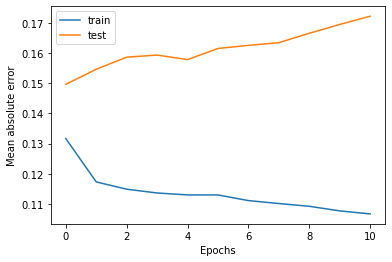

Root mean square error: 11062.4033203125
MAPE: 0.2687646795760825
MAE: 7509.172182932208
R2 score: 0.3588373179027742
 
 
---------------------------------------------------
Train on 35020 samples, validate on 600 samples
Epoch 1/100
35020/35020 [==============================] - 11s 314us/sample - loss: 0.1332 - val_loss: 0.1263
Epoch 2/100
35020/35020 [==============================] - 3s 86us/sample - loss: 0.1185 - val_loss: 0.1343
Epoch 3/100
35020/35020 [==============================] - 3s 80us/sample - loss: 0.1164 - val_loss: 0.1358
Epoch 4/100
35020/35020 [==============================] - 3s 81us/sample - loss: 0.1146 - val_loss: 0.1326
Epoch 5/100
35020/35020 [==============================] - 3s 82us/sample - loss: 0.1136 - val_loss: 0.1388
Epoch 6/100
35020/35020 [==============================] - 3s 81us/sample - loss: 0.1127 - val_loss: 0.1470
Epoch 7/100
35020/35020 [==============================] - 3s 83us/sample - loss: 0.1120 - val_loss: 0.1374
Epoch 8/100
35020/35

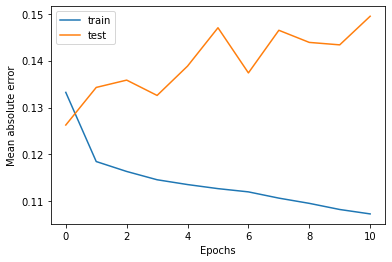

Root mean square error: 9758.0283203125
MAPE: 0.695155713094864
MAE: 6335.961394856771
R2 score: -0.2642537894333561
 
 
---------------------------------------------------
Train on 35620 samples, validate on 620 samples
Epoch 1/100
35620/35620 [==============================] - 9s 263us/sample - loss: 0.1325 - val_loss: 0.0793
Epoch 2/100
35620/35620 [==============================] - 3s 84us/sample - loss: 0.1184 - val_loss: 0.0784
Epoch 3/100
35620/35620 [==============================] - 3s 88us/sample - loss: 0.1160 - val_loss: 0.0768
Epoch 4/100
35620/35620 [==============================] - 3s 88us/sample - loss: 0.1159 - val_loss: 0.0784
Epoch 5/100
35620/35620 [==============================] - 3s 85us/sample - loss: 0.1143 - val_loss: 0.0776
Epoch 6/100
35620/35620 [==============================] - 3s 82us/sample - loss: 0.1131 - val_loss: 0.0753
Epoch 7/100
35620/35620 [==============================] - 3s 87us/sample - loss: 0.1120 - val_loss: 0.0790
Epoch 8/100
35620/3562

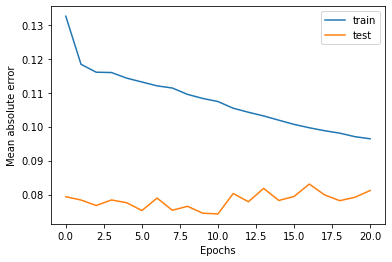

Root mean square error: 5727.767578125
MAPE: 0.1424945962938534
MAE: 3727.668521610383
R2 score: 0.4502723321775489
 
 
---------------------------------------------------


In [16]:
# Testing
# lag=14
ds=['october','november','december']

data_LSTM_X1,data_LSTM_X2, data_LSTM_X3, data_LSTM_Y = sequence_data_build(data, lag)
totday=int(data_LSTM_X1.shape[0]/20)
m1 = [totday-61, totday-31, totday, ]
m2 = [m1[0]-31, m1[1]-30, m1[2]-31, ]
for i in range(len(m1)):
    trainX1, trainY, testX1, testY= train_test_build(data_LSTM_X1, data_LSTM_Y, m1[i], m2[i])
    trainX2, trainY, testX2, testY= train_test_build(data_LSTM_X2, data_LSTM_Y, m1[i], m2[i])
    trainX3, trainY, testX3, testY= train_test_build(data_LSTM_X3, data_LSTM_Y, m1[i], m2[i])
    testYcopy=testY
    saving = True
    EarlyStop = True
    rmse, mape, mae, r2, history = model_build(trainX1, trainX2, trainX3, testX1, testX2, testX3, trainY, testY, units, saving, ds[i], EarlyStop)
        
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.xlabel("Epochs")
    pyplot.ylabel("Mean absolute error")
    pyplot.savefig("SMP3_" + ds[i] + ".png")
    pyplot.show()
    
    
    print("Root mean square error: {0}".format(rmse))
    print("MAPE: {0}".format(mape))
    print("MAE: {0}".format(mae))
    print("R2 score: {0}".format(r2))
    print(" ")
    print(" ")
    print("---------------------------------------------------")

In [17]:
print("lag vector")
print(lag_vec)
print("LSTM units")
print(units_vec)
print("Cross validation results")
print(lag,units)
print("----------------------------")
print("RMSE")
print(results[0,:])

print("----------------------------")
print("MAE")
print(results[1,:])

print("----------------------------")
print("MAPE")
print(results[2,:])

print("----------------------------")
print("R2-score")
print(results[3,:])

lag vector
[7, 14]
LSTM units
[2, 4, 8, 16, 32, 64, 128]
Cross validation results
14 128
----------------------------
RMSE
[[[5862.04199219 5413.99902344 4400.63134766 5880.10498047 5795.38720703
   5551.18164062 4261.34912109]
  [5210.70166016 4695.95849609 5230.31591797 4377.95556641 4273.95898438
   4014.49633789 3999.69091797]]

 [[6083.08837891 5336.98535156 4942.62011719 5056.89501953 4426.07519531
   4757.82617188 4351.19091797]
  [5194.64111328 5087.05371094 4878.89453125 4903.99511719 6229.44677734
   5000.66796875 4470.47753906]]

 [[7610.06396484 6330.91357422 6255.43310547 6380.15869141 6298.94042969
   6476.23974609 6419.67871094]
  [6679.31738281 7153.29882812 6611.67675781 6399.61523438 6439.21289062
   6464.48974609 6391.67382812]]]
----------------------------
MAE
[[[0.26687783 0.242578   0.16269596 0.27332142 0.22887758 0.17254396
   0.13314255]
  [0.19681708 0.17059713 0.20549043 0.14844073 0.1544768  0.12746374
   0.11476927]]

 [[0.25658765 0.25287587 0.19729199 0.